# VAE 분석 - 얼굴 데이터셋

*Note: 최신 버전의 라이브러리를 사용하기 때문에 책의 내용과 결과가 다를 수 있습니다*

## 라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

Using TensorFlow backend.


In [2]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## 데이터 적재

In [3]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [4]:
att.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

## 모델 만들기

In [5]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 얼굴 이미지 재구성

Found 202599 images.


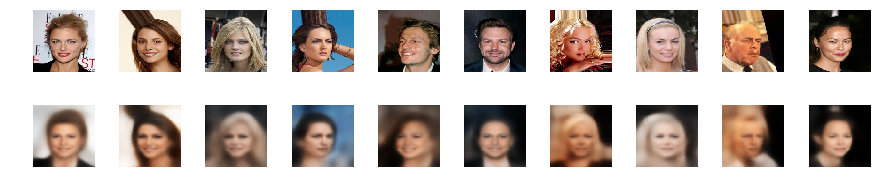

In [6]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

## 잠재 공간 분포

20/20 [==============================] - 4s 177ms/step


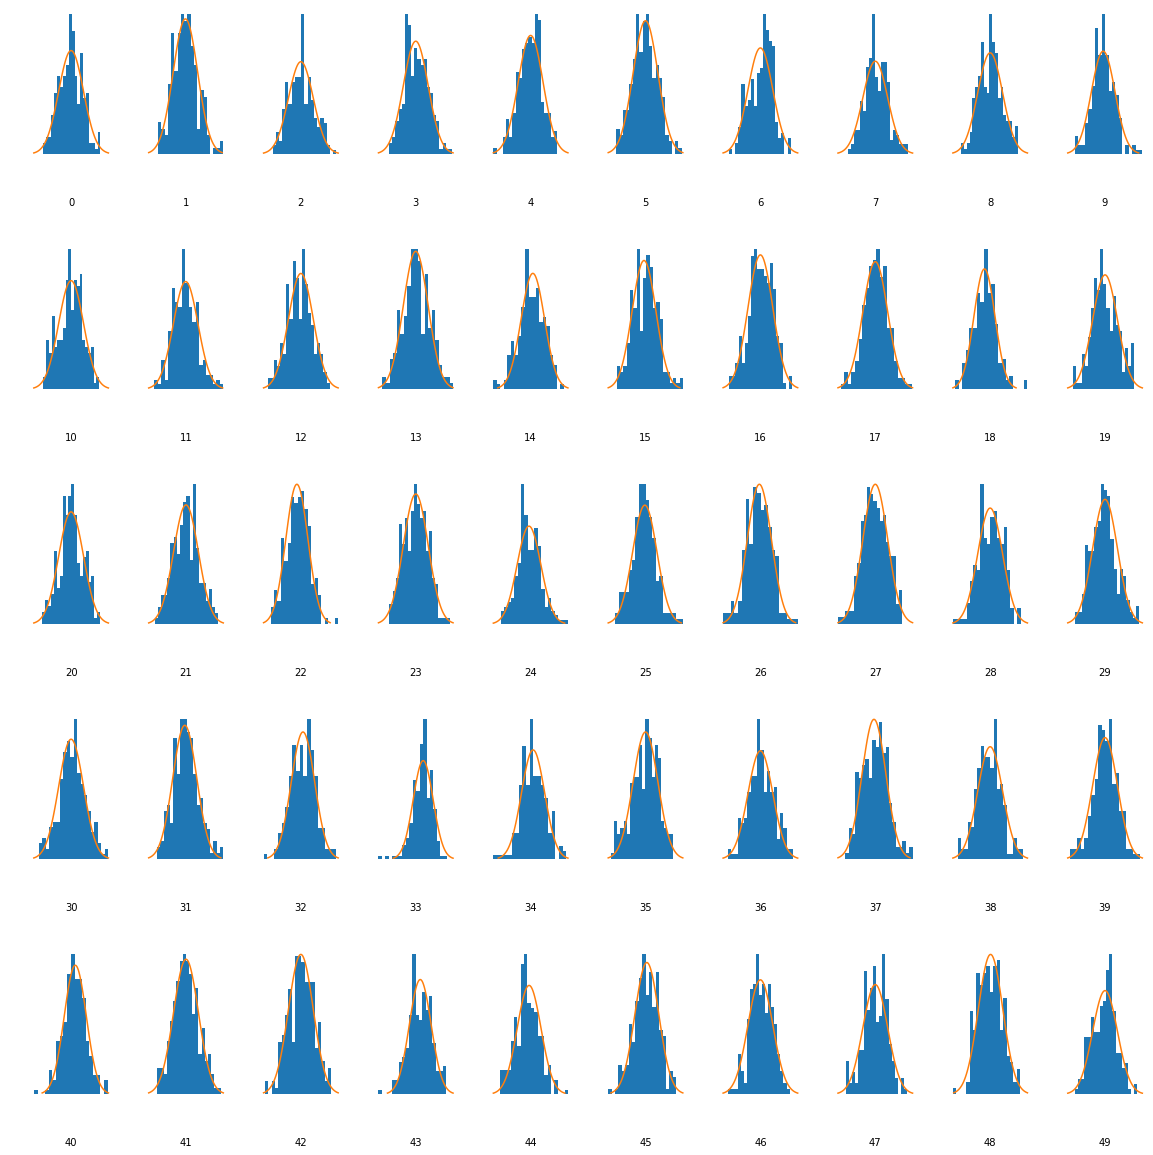

In [7]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### 새로 생성한 얼굴

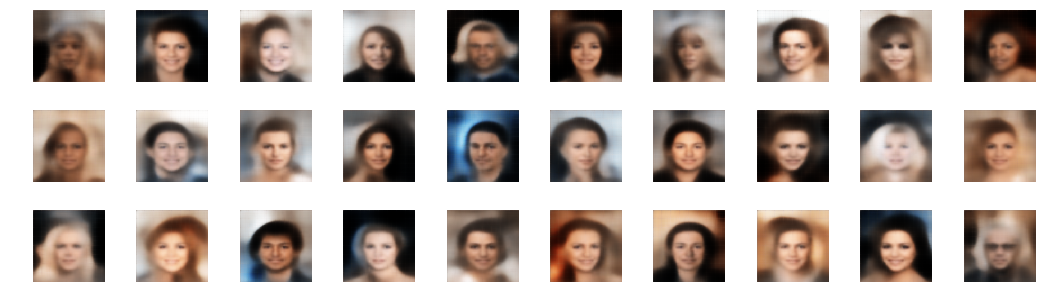

In [8]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [9]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   

In [10]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1
    
    plt.show()

In [11]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 images.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
266    : 0.898    : 1.004    : 1.493    : 1.493
537    : 0.564    : 0.66    : 1.263    : -0.229
789    : 0.338    : 0.387    : 1.131    : -0.132
1050    : 0.236    : 0.255    : 1.049    : -0.082
1327    : 0.191    : 0.209    : 1.039    : -0.01
1584    : 0.167    : 0.168    : 1.006    : -0.033
1834    : 0.133    : 0.121    : 0.985    : -0.021
2088    : 0.113    : 0.117    : 0.996    : 0.011
2338    : 0.104    : 0.102    : 0.981    : -0.015
2603    : 0.09    : 0.087    : 0.966    : -0.015
2880    : 0.083    : 0.088    : 0.971    : 0.005
3135    : 0.074    : 0.079    : 0.968    : -0.003
3396    : 0.07    : 0.071    : 0.966    : -0.002
3644    : 0.062    : 0.074    : 0.958    : -0.008
3894    : 0.06    : 0.071    : 0.951    : -0.007
4170    : 0.055    : 0.057    : 0.966    : 0.015
4429    : 0.052    : 0.056    : 0.967    : 0.001
4668    : 0.045    : 0.06    : 0.965    : -0.001
4915    : 0.044    : 0.

In [12]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 images.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
36    : 2.66    : 0.673    : 2.737    : 2.737
66    : 1.524    : 0.469    : 2.245    : -0.492
104    : 1.063    : 0.258    : 2.04    : -0.205
129    : 0.621    : 0.189    : 1.921    : -0.119
163    : 0.571    : 0.143    : 1.79    : -0.131
196    : 0.452    : 0.111    : 1.713    : -0.078
222    : 0.337    : 0.103    : 1.699    : -0.014
251    : 0.334    : 0.084    : 1.683    : -0.016
276    : 0.267    : 0.076    : 1.656    : -0.027
302    : 0.249    : 0.068    : 1.629    : -0.027
340    : 0.267    : 0.064    : 1.6    : -0.03
366    : 0.192    : 0.054    : 1.568    : -0.031
398    : 0.195    : 0.053    : 1.584    : 0.015
435    : 0.219    : 0.048    : 1.581    : -0.003
459    : 0.167    : 0.044    : 1.591    : 0.01
496    : 0.176    : 0.04    : 1.582    : -0.009
530    : 0.156    : 0.039    : 1.587    : 0.004
563    : 0.152    : 0.036    : 1.569    : -0.018
597    : 0.147    : 0.036    : 1.533    :

In [13]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 images.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
73    : 1.967    : 0.683    : 2.162    : 2.162
161    : 1.097    : 0.444    : 1.754    : -0.408
231    : 0.556    : 0.295    : 1.689    : -0.065
317    : 0.47    : 0.199    : 1.619    : -0.07
386    : 0.346    : 0.145    : 1.612    : -0.007
458    : 0.262    : 0.124    : 1.596    : -0.015
529    : 0.253    : 0.1    : 1.547    : -0.049
600    : 0.206    : 0.088    : 1.53    : -0.018
675    : 0.19    : 0.079    : 1.495    : -0.034
737    : 0.157    : 0.071    : 1.509    : 0.014
818    : 0.172    : 0.06    : 1.496    : -0.014
882    : 0.123    : 0.06    : 1.499    : 0.004
957    : 0.133    : 0.053    : 1.513    : 0.013
1023    : 0.118    : 0.048    : 1.508    : -0.004
1096    : 0.11    : 0.045    : 1.496    : -0.013
1163    : 0.105    : 0.047    : 1.495    : -0.001
1243    : 0.106    : 0.044    : 1.5    : 0.005
1311    : 0.086    : 0.04    : 1.499    : -0.001
1390    : 0.093    : 0.039    : 1.49    

Attractive Vector


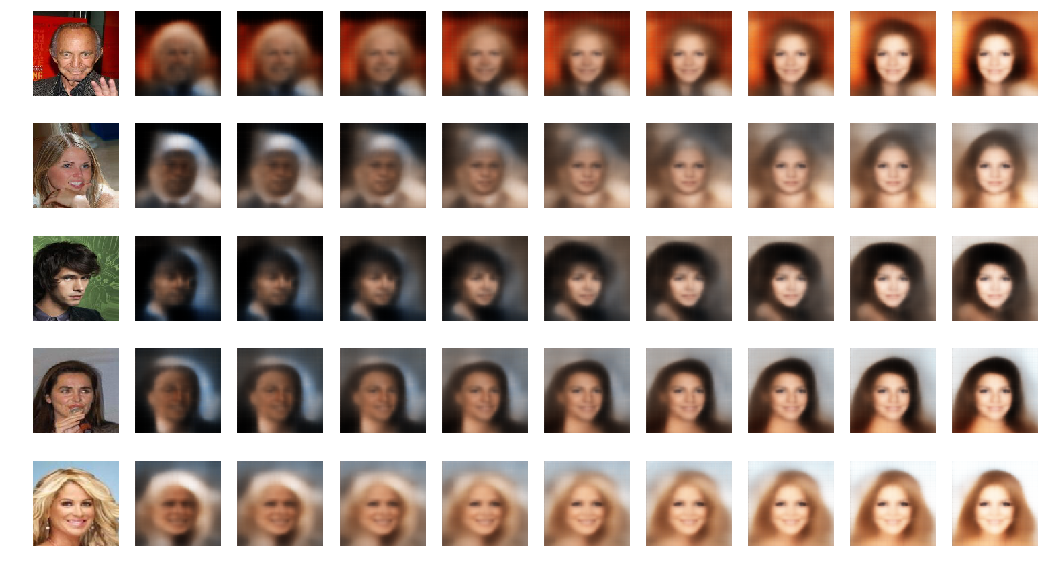

Mouth Open Vector


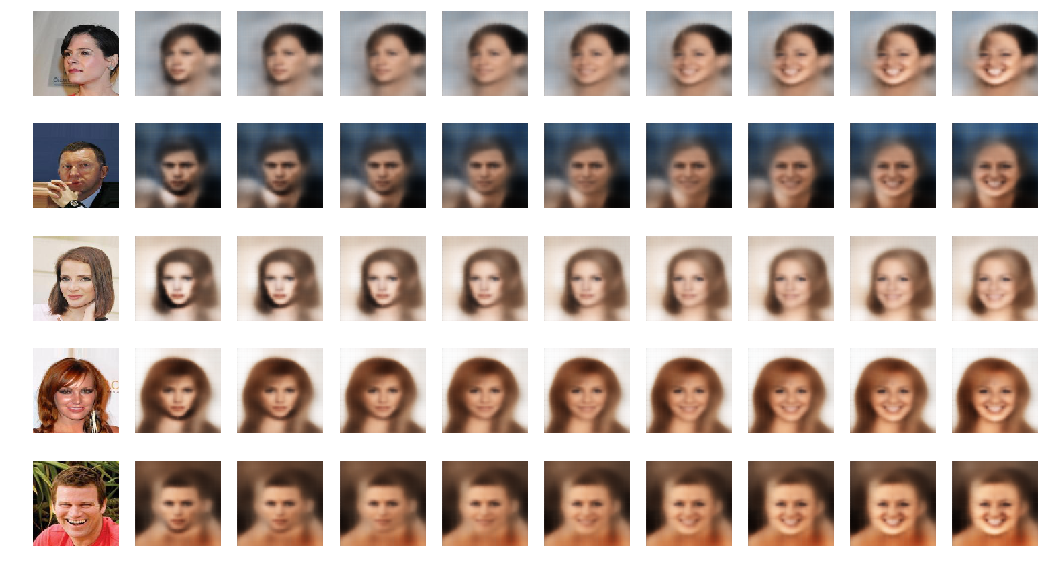

Smiling Vector


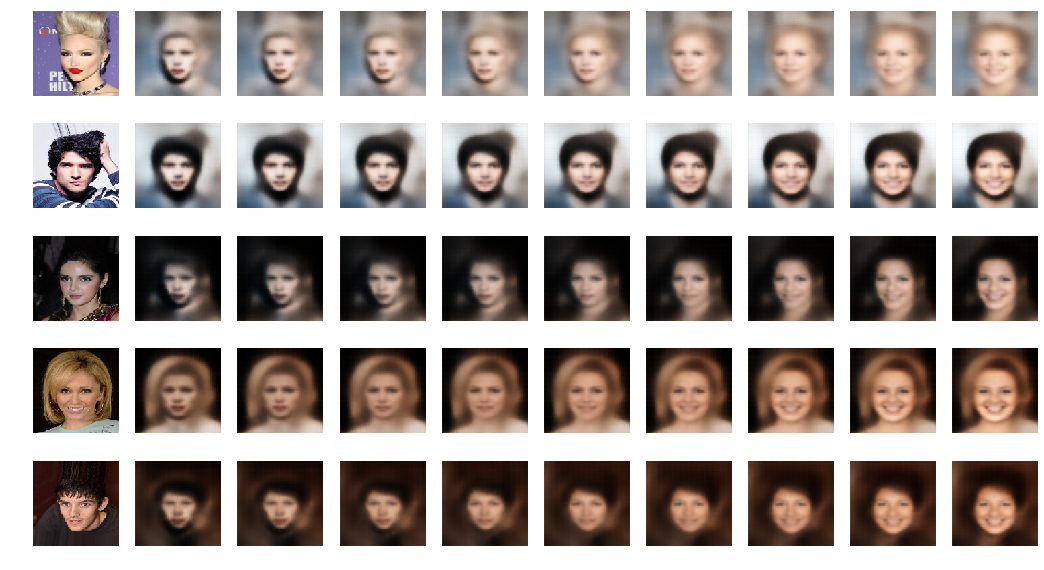

Lipstick Vector


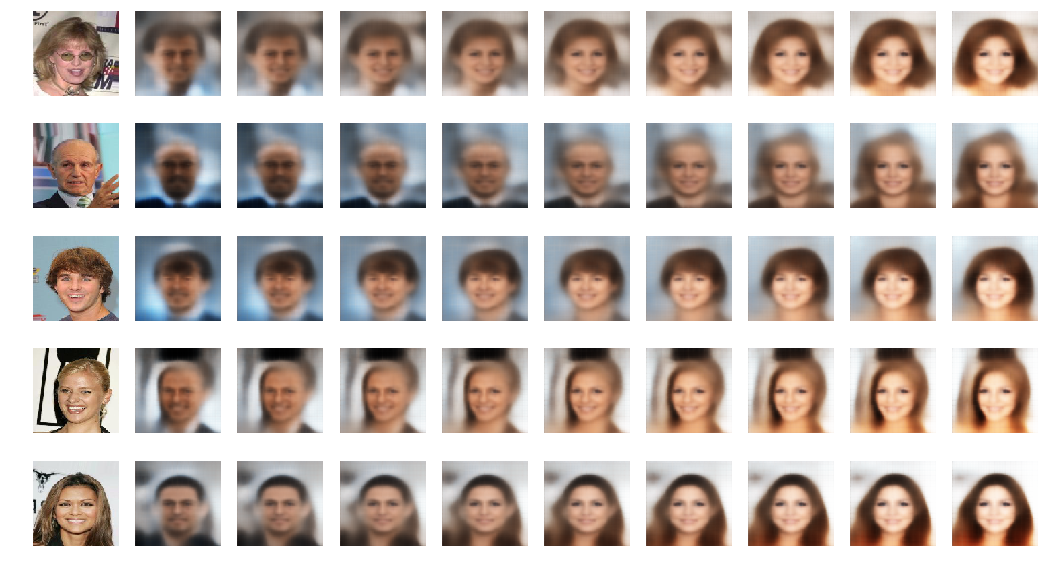

Young Vector


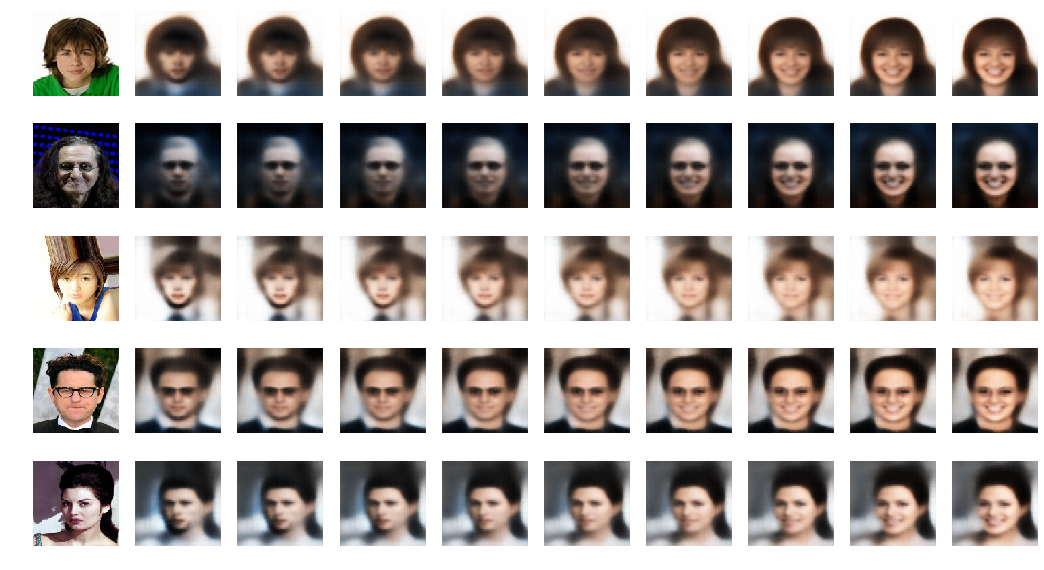

Male Vector


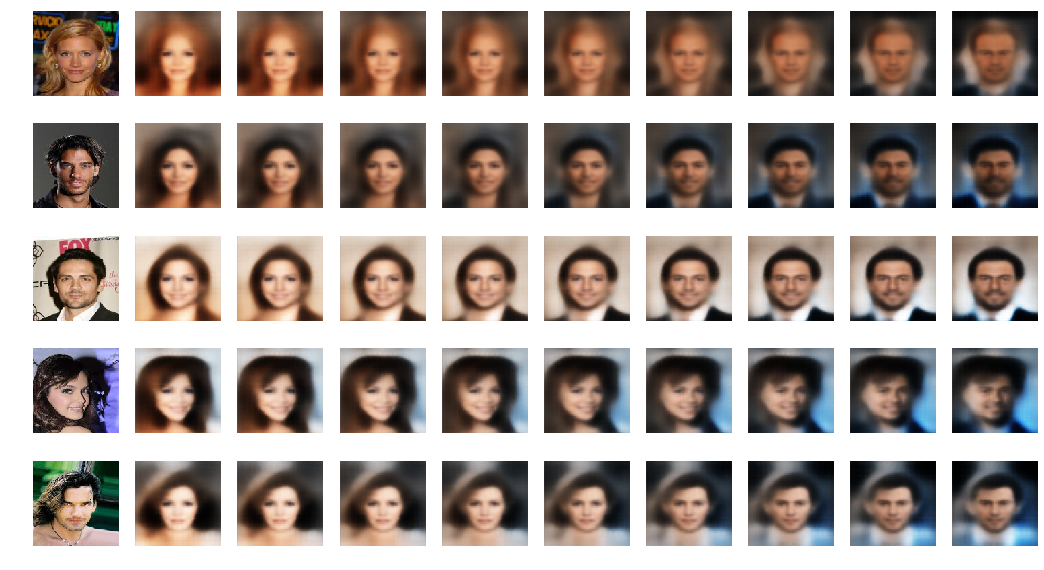

Eyeglasses Vector


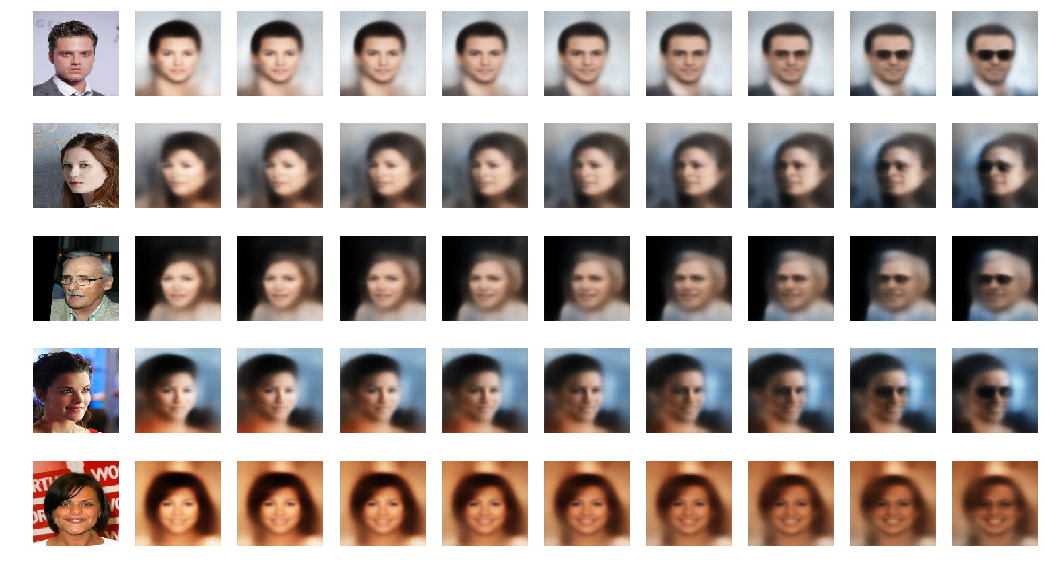

Blond Vector


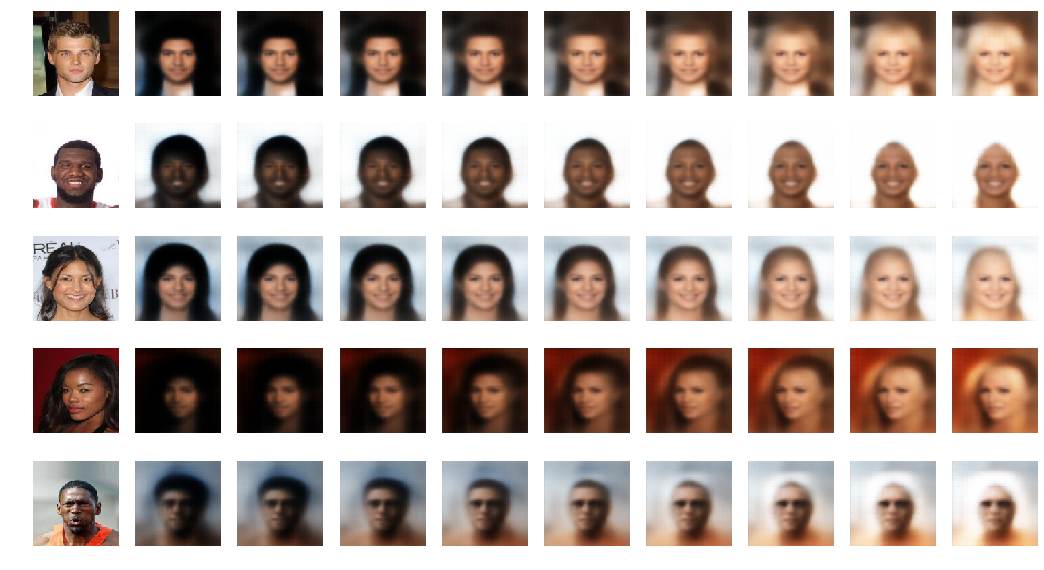

In [14]:
print('Attractive Vector')
add_vector_to_images(attractive_vec)

print('Mouth Open Vector')
add_vector_to_images(mouth_open_vec)

print('Smiling Vector')
add_vector_to_images(smiling_vec)

print('Lipstick Vector')
add_vector_to_images(lipstick_vec)

print('Young Vector')
add_vector_to_images(young_vec)

print('Male Vector')
add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

print('Blond Vector')
add_vector_to_images(blonde_vec)

In [15]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    plt.show()

Found 2 images.


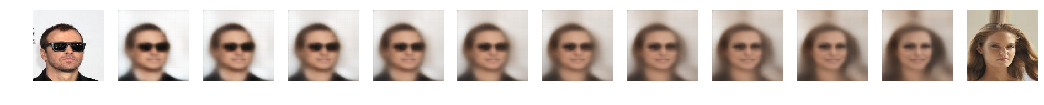

In [16]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 images.


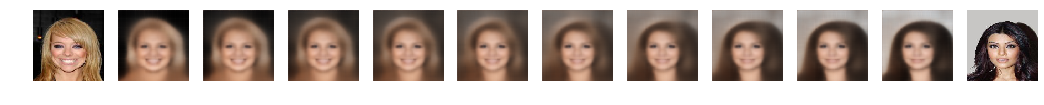

In [17]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 images.


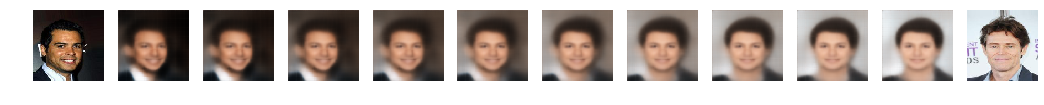

In [18]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)